In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

## Reflect Tables into SQLALchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
degree_sign= u'\N{DEGREE SIGN}'

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start, end):
    
    try:
        start_date = datetime.strptime(start, '%Y%m%d')
        end_date = datetime.strptime(end, '%Y%m%d')
    except:
        return (f"This is the incorrect date format. It should be YYYYMMDD<br/>")
    
    start_date = start_date - dt.timedelta(days=365)
    end_date = end_date - dt.timedelta(days=365)
    
    session = Session(engine)
    temp_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),\
                                 func.max(Measurement.tobs)).filter(Measurement.date.between(start_date, end_date)).all()
    session.close()
#     for tmin, tavg, tmax in temp_results:
#         return(f"Tmin={tmin}{degree_sign}F, Tavg={round(tavg, 2)}{degree_sign}F and Tmax={tmax}{degree_sign}F")
    return temp_results

In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
temp_results = calc_temps('20151010', '20151110')
temp_results

[(63.0, 76.01834862385321, 84.0)]

(0.0, 106.01834862385321)

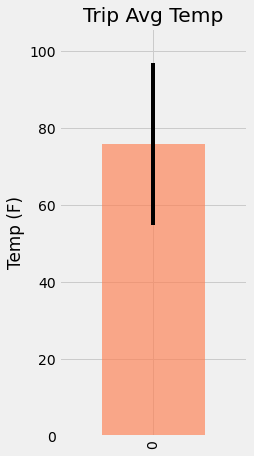

In [88]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

for tmin, tavg, tmax in temp_results:
        temp_dict = {}
        temp_dict['tmin'] = tmin
        temp_dict['tavg'] = tavg
        temp_dict['tmax'] = tmax

temp_info = pd.DataFrame(temp_dict, index=[0]) 
yerr= [temp_info['tmax'] - temp_info['tmin']]

temp_info['tavg'].plot.bar(yerr=yerr, width=0.6, alpha = 0.65, color='coral', figsize=(3, 7))
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.ylim(0, temp_info['tavg'].values+30)

### Daily Rainfall Average

In [37]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session = Session(engine)
# year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
rainfall = session.query(Measurement.station, Station.name, func.avg(Measurement.prcp), Station.latitude, \
                         Station.longitude, Station.elevation).filter(Measurement.station == Station.station). \
                         order_by(desc(func.avg(Measurement.prcp))).group_by(Measurement.station).all()
rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  0.4299879227053122,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.2123520923520915,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  0.20722222222222236,
  21.4992,
  -158.0111,
  306.6),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  0.14192136498516264,
  21.4234,
  -157.8015,
  14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.12105833763551899,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.11496111975116619,
  21.33556,
  -157.71139,
  19.5),
 ('USC00517948',
  'PEARL CITY, HI US',
  0.06360175695461204,
  21.3934,
  -157.9751,
  11.9),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  0.0490204841713224,
  21.2716,
  -157.8168,
  3.0),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  0.04797101449275366,
  21.3152,
  -157.9992,
  0.9)]

In [117]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(start, end):

    try:
#         start_date = datetime.strptime(start, '%m%d')
#         end_date = datetime.strptime(end, '%m%d')
        start_date = datetime.strptime(start, '%Y-%m-%d').strftime("%m-%d")
        end_date = datetime.strptime(end, '%Y-%m-%d').strftime("%m-%d")

    except:
        return (f"This is the incorrect date format. It should be MMDD<br/>")
    session = Session(engine)    
    daily_normals = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), \
                                  func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date.between(start_date, end_date))).group_by(func.strftime("%m-%d", Measurement.date)).all()
    session.close()
    normals_list = []
    for date, tmin, tavg, tmax in daily_normals:
        normals_dict = {}
        normals_dict['date'] = date
        normals_dict['tmin'] = tmin
        normals_dict['tavg'] = tavg
        normals_dict['tmax'] = tmax
        normals_list.append(normals_dict)
    
    normals_df = pd.DataFrame(normals_list)
    return normals_df

# # For example
# daily_normals("01-01")

In [118]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

normals_df = daily_normals(start_date, end_date)
normals_df

,date,tmin,tavg,tmax
0,2011-01-01,62.0,69.153846,77.0
1,2014-01-02,60.0,69.396226,77.0
2,2010-01-03,62.0,68.909091,77.0
3,2010-01-04,58.0,70.000000,76.0
4,2010-01-05,56.0,67.964286,76.0
...,...,...,...,...
361,2013-12-27,62.0,71.916667,79.0
362,2015-12-28,62.0,70.520833,77.0
363,2012-12-29,57.0,70.291667,78.0
364,2012-12-30,63.0,69.863636,76.0


In [96]:
start_date = '2017-08-01'
end_date = '2017-08-07'
start_date = datetime.strptime(start_date, '%Y-%m-%d').strftime("%m-%d")
end_date = datetime.strptime(end_date, '%Y-%m-%d').strftime("%m-%d")

session = Session(engine)
daily_normals = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date.between(start_date, end_date))).group_by(func.strftime("%m-%d", Measurement.date)).all()
session.close()
# for date, tmin, tavg, tmax in daily_normals:
#     print(date, tmin, tavg, tmax)
daily_normals

[('2011-01-01', 62.0, 69.15384615384616, 77.0),
 ('2014-01-02', 60.0, 69.39622641509433, 77.0),
 ('2010-01-03', 62.0, 68.9090909090909, 77.0),
 ('2010-01-04', 58.0, 70.0, 76.0),
 ('2010-01-05', 56.0, 67.96428571428571, 76.0),
 ('2010-01-06', 61.0, 68.96491228070175, 76.0),
 ('2016-01-07', 57.0, 68.54385964912281, 76.0),
 ('2016-01-08', 57.0, 67.16071428571429, 75.0),
 ('2016-01-09', 58.0, 67.9298245614035, 78.0),
 ('2015-01-10', 62.0, 69.74137931034483, 77.0),
 ('2017-01-11', 57.0, 67.3103448275862, 78.0),
 ('2017-01-12', 57.0, 67.4074074074074, 81.0),
 ('2013-01-13', 57.0, 67.25454545454545, 77.0),
 ('2017-01-14', 58.0, 69.52631578947368, 77.0),
 ('2017-01-15', 56.0, 69.31372549019608, 78.0),
 ('2017-01-16', 54.0, 68.62962962962963, 80.0),
 ('2012-01-17', 61.0, 69.07407407407408, 76.0),
 ('2010-01-18', 57.0, 68.63157894736842, 77.0),
 ('2012-01-19', 60.0, 68.26315789473684, 78.0),
 ('2012-01-20', 61.0, 68.86666666666666, 78.0),
 ('2012-01-21', 61.0, 70.14545454545454, 76.0),
 ('2011-0

In [58]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session

In [ ]:
session.close()